In [ ]:
!pip install dm-control==1.0.14 torch matplotlib numpy --quiet
!pip uninstall -y dm-control mujoco
!pip install -U dm-control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.3/39.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.1 MB/s eta 0:00:00
Found existing installation: dm-control 1.0.14
Uninstalling dm-control-1.0.14:
  Successfully uninstalled dm-control-1.0.14
Found existing installation: mujoco 3.3.7
Uninstalling mujoco-3.3.7:
  Successfully uninstalled mujoco-3.3.7
  Using cached mujoco-3.3.7-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (41 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.4/56.4 MB 12.4 MB/s eta 0:00:00
Using cached mujoco-3.3.7-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (6.9 MB)


In [ ]:
import os
os.environ["MUJOCO_GL"] = "egl"

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal
from dm_control import suite

print("PyTorch version:", torch.__version__)
print("NumPy version:", np.__version__)

PyTorch version: 2.9.0+cu126
NumPy version: 2.0.2


In [ ]:
class DMControlCartpoleWrapper:
    """Simple Gym-like wrapper for dm_control cartpole, balance."""

    def __init__(self, domain_name="cartpole", task_name="balance", seed=None):
        # Seed numpy and torch here (env seeding is a bit limited in dm_control)
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

        # Load dm_control environment
        self._env = suite.load(domain_name=domain_name, task_name=task_name)

        # Specs
        self._obs_spec = self._env.observation_spec()
        self._act_spec = self._env.action_spec()

        # Flattened observation size
        self.obs_dim = int(sum(np.prod(v.shape) for v in self._obs_spec.values()))
        # Action dimension
        self.act_dim = int(np.prod(self._act_spec.shape))

        # For convenience: action bounds (numpy arrays)
        self.act_low = self._act_spec.minimum
        self.act_high = self._act_spec.maximum

    def _flatten_obs(self, time_step):
        """Convert dm_control TimeStep observation dict to a 1D float32 numpy array."""
        obs_list = []
        for v in time_step.observation.values():
            obs_list.append(np.array(v, dtype=np.float32).ravel())
        obs = np.concatenate(obs_list, axis=0)
        return obs

    def reset(self):
        """Reset the environment. Returns state (1D numpy array)."""
        time_step = self._env.reset()
        obs = self._flatten_obs(time_step)
        return obs

    def step(self, action):
        """
        Step the environment.
        action: numpy array with shape (act_dim,)
        Returns: next_obs, reward, done, info(dict)
        """
        # Clip action to env bounds for safety
        action = np.clip(action, self.act_low, self.act_high)

        time_step = self._env.step(action)

        next_obs = self._flatten_obs(time_step)
        reward = float(time_step.reward) if time_step.reward is not None else 0.0
        done = bool(time_step.last())

        info = {}  # we do not use info for now
        return next_obs, reward, done, info

In [ ]:
env = DMControlCartpoleWrapper(seed=0)
print("obs_dim:", env.obs_dim)
print("act_dim:", env.act_dim)
print("act_low:", env.act_low)
print("act_high:", env.act_high)

state = env.reset()
print("Initial state shape:", state.shape)

# Run one random episode
episode_return = 0.0
state = env.reset()
for t in range(200):
    action = np.random.uniform(env.act_low, env.act_high, size=(env.act_dim,))
    next_state, reward, done, info = env.step(action)
    episode_return += reward
    if done:
        break

print("Random policy episode return:", episode_return)

obs_dim: 5
act_dim: 1
act_low: [-1.]
act_high: [1.]
Initial state shape: (5,)
Random policy episode return: 108.8048160623639


In [ ]:
class ActorCritic(nn.Module):
    """Shared backbone with separate actor and critic heads for PPO."""

    def __init__(self, obs_dim, act_dim, hidden_size=64):
        super().__init__()

        # Shared feature extractor
        self.shared = nn.Sequential(
            nn.Linear(obs_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
        )

        # Actor head: output mean of Gaussian
        self.mu_layer = nn.Linear(hidden_size, act_dim)

        # Log std parameter (one per action dimension, learnable)
        self.log_std = nn.Parameter(torch.zeros(act_dim))

        # Critic head: output scalar value
        self.v_layer = nn.Linear(hidden_size, 1)

    def forward(self, x):
        """Forward pass that returns mu, log_std, value."""
        features = self.shared(x)
        mu = self.mu_layer(features)
        log_std = self.log_std.expand_as(mu)
        value = self.v_layer(features).squeeze(-1)
        return mu, log_std, value

    def get_action_and_value(self, obs):
        """
        Given observations (tensor), sample action, compute log_prob, entropy and value.
        obs: shape (batch, obs_dim)
        """
        mu, log_std, value = self.forward(obs)
        std = torch.exp(log_std)
        dist = Normal(mu, std)

        action = dist.sample()
        log_prob = dist.log_prob(action).sum(axis=-1)
        entropy = dist.entropy().sum(axis=-1)

        return action, log_prob, entropy, value

    def get_log_prob_and_value(self, obs, action):
        """
        Given observations and actions, recompute log_prob and value.
        Used during PPO update.
        """
        mu, log_std, value = self.forward(obs)
        std = torch.exp(log_std)
        dist = Normal(mu, std)

        log_prob = dist.log_prob(action).sum(axis=-1)
        entropy = dist.entropy().sum(axis=-1)

        return log_prob, entropy, value

In [ ]:
obs_dim = env.obs_dim
act_dim = env.act_dim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = ActorCritic(obs_dim, act_dim).to(device)

dummy_obs = torch.zeros((4, obs_dim), device=device)  # batch of 4
with torch.no_grad():
    action, log_prob, entropy, value = model.get_action_and_value(dummy_obs)

print("Action shape:", action.shape)
print("Log_prob shape:", log_prob.shape)
print("Value shape:", value.shape)

Using device: cuda
Action shape: torch.Size([4, 1])
Log_prob shape: torch.Size([4])
Value shape: torch.Size([4])


In [ ]:
class RolloutBuffer:
    """Stores transitions for one PPO update."""

    def __init__(self, buffer_size, obs_dim, act_dim, device):
        self.buffer_size = buffer_size
        self.device = device

        self.states = np.zeros((buffer_size, obs_dim), dtype=np.float32)
        self.actions = np.zeros((buffer_size, act_dim), dtype=np.float32)
        self.rewards = np.zeros(buffer_size, dtype=np.float32)
        self.dones = np.zeros(buffer_size, dtype=np.float32)
        self.log_probs = np.zeros(buffer_size, dtype=np.float32)
        self.values = np.zeros(buffer_size, dtype=np.float32)

        self.ptr = 0

    def add(self, state, action, reward, done, log_prob, value):
        idx = self.ptr
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.dones[idx] = done
        self.log_probs[idx] = log_prob
        self.values[idx] = value
        self.ptr += 1

    def is_full(self):
        return self.ptr >= self.buffer_size

    def clear(self):
        self.ptr = 0

    def compute_returns_and_advantages(self, last_value, gamma=0.99, gae_lambda=0.95):
        """
        Compute GAE advantages and returns.
        last_value: value estimate for the last state (after final step).
        Returns: tensors (states, actions, log_probs, returns, advantages)
        """
        buffer_size = self.ptr

        rewards = self.rewards[:buffer_size]
        dones = self.dones[:buffer_size]
        values = self.values[:buffer_size]
        # Append last_value to simplify recursion
        values_ext = np.concatenate([values, np.array([last_value], dtype=np.float32)])

        advantages = np.zeros(buffer_size, dtype=np.float32)
        last_gae = 0.0

        for t in reversed(range(buffer_size)):
            non_terminal = 1.0 - dones[t]
            delta = rewards[t] + gamma * values_ext[t + 1] * non_terminal - values_ext[t]
            last_gae = delta + gamma * gae_lambda * non_terminal * last_gae
            advantages[t] = last_gae

        returns = advantages + values

        # Convert to PyTorch tensors
        states = torch.tensor(self.states[:buffer_size], dtype=torch.float32, device=self.device)
        actions = torch.tensor(self.actions[:buffer_size], dtype=torch.float32, device=self.device)
        old_log_probs = torch.tensor(self.log_probs[:buffer_size], dtype=torch.float32, device=self.device)
        returns = torch.tensor(returns, dtype=torch.float32, device=self.device)
        advantages = torch.tensor(advantages, dtype=torch.float32, device=self.device)

        # Normalize advantages (helps stability)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        return states, actions, old_log_probs, returns, advantages


========== Training for seed 0 ==========
[Seed 0] Using device: cuda
[Seed 0] Update 001/100 | Train return: 236.00 | Eval return: 271.03
[Seed 0] Update 002/100 | Train return: 253.86 | Eval return: 284.96
[Seed 0] Update 003/100 | Train return: 294.38 | Eval return: 298.09
[Seed 0] Update 004/100 | Train return: 220.92 | Eval return: 220.75
[Seed 0] Update 005/100 | Train return: 239.69 | Eval return: 322.24
[Seed 0] Update 006/100 | Train return: 300.60 | Eval return: 293.75
[Seed 0] Update 007/100 | Train return: 260.70 | Eval return: 301.07
[Seed 0] Update 008/100 | Train return: 269.95 | Eval return: 301.88
[Seed 0] Update 009/100 | Train return: 273.56 | Eval return: 369.45
[Seed 0] Update 010/100 | Train return: 355.34 | Eval return: 477.08
[Seed 0] Update 011/100 | Train return: 279.75 | Eval return: 353.02
[Seed 0] Update 012/100 | Train return: 296.73 | Eval return: 288.30
[Seed 0] Update 013/100 | Train return: 336.95 | Eval return: 361.29
[Seed 0] Update 014/100 | Train 

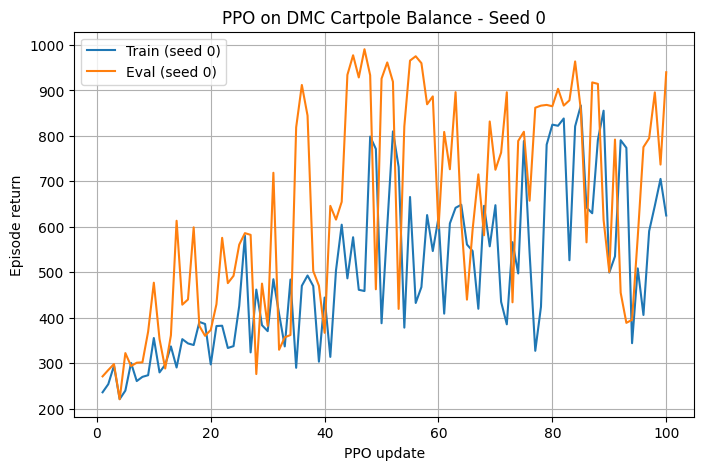


========== Training for seed 1 ==========
[Seed 1] Using device: cuda
[Seed 1] Update 001/100 | Train return: 204.07 | Eval return: 218.77
[Seed 1] Update 002/100 | Train return: 258.35 | Eval return: 248.03
[Seed 1] Update 003/100 | Train return: 237.70 | Eval return: 279.15
[Seed 1] Update 004/100 | Train return: 225.01 | Eval return: 316.61
[Seed 1] Update 005/100 | Train return: 327.45 | Eval return: 302.26
[Seed 1] Update 006/100 | Train return: 308.09 | Eval return: 363.99
[Seed 1] Update 007/100 | Train return: 360.10 | Eval return: 395.84
[Seed 1] Update 008/100 | Train return: 257.65 | Eval return: 404.52
[Seed 1] Update 009/100 | Train return: 364.78 | Eval return: 426.68
[Seed 1] Update 010/100 | Train return: 336.81 | Eval return: 360.26
[Seed 1] Update 011/100 | Train return: 346.28 | Eval return: 316.05
[Seed 1] Update 012/100 | Train return: 278.42 | Eval return: 286.03
[Seed 1] Update 013/100 | Train return: 242.25 | Eval return: 253.30
[Seed 1] Update 014/100 | Train 

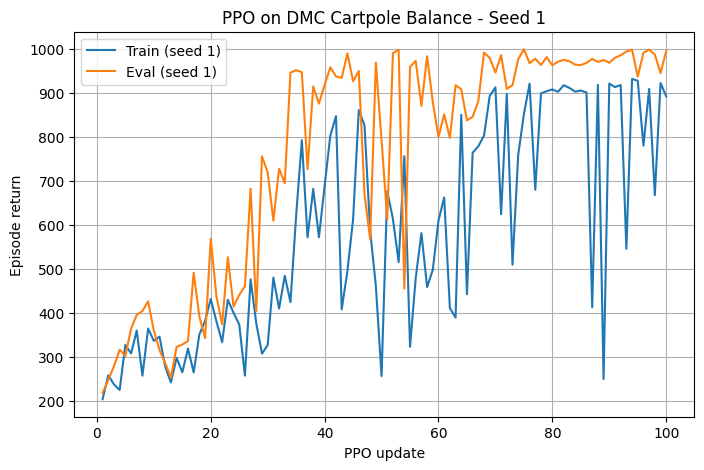


========== Training for seed 2 ==========
[Seed 2] Using device: cuda
[Seed 2] Update 001/100 | Train return: 274.44 | Eval return: 214.08
[Seed 2] Update 002/100 | Train return: 226.78 | Eval return: 252.66
[Seed 2] Update 003/100 | Train return: 379.18 | Eval return: 491.15
[Seed 2] Update 004/100 | Train return: 307.70 | Eval return: 372.54
[Seed 2] Update 005/100 | Train return: 275.57 | Eval return: 419.05
[Seed 2] Update 006/100 | Train return: 318.50 | Eval return: 345.14
[Seed 2] Update 007/100 | Train return: 285.49 | Eval return: 397.89
[Seed 2] Update 008/100 | Train return: 384.72 | Eval return: 444.49
[Seed 2] Update 009/100 | Train return: 264.05 | Eval return: 325.64
[Seed 2] Update 010/100 | Train return: 304.58 | Eval return: 475.23
[Seed 2] Update 011/100 | Train return: 305.26 | Eval return: 304.48
[Seed 2] Update 012/100 | Train return: 296.93 | Eval return: 315.97
[Seed 2] Update 013/100 | Train return: 377.92 | Eval return: 564.15
[Seed 2] Update 014/100 | Train 

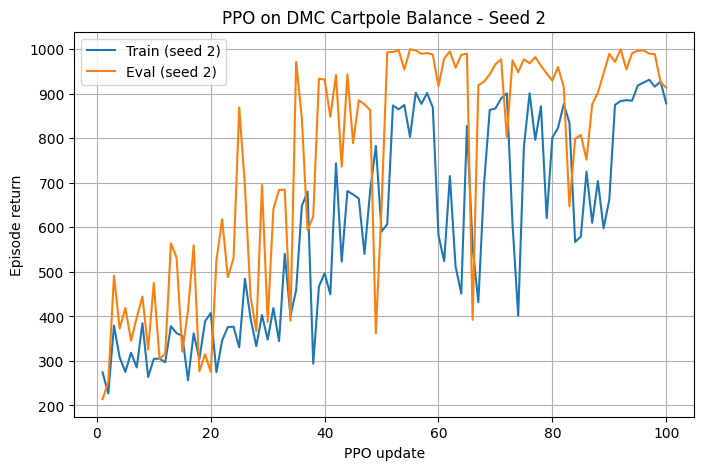


=== Finished all seeds ===
all_train_returns shape: (3, 100)
all_eval_returns shape: (3, 100)


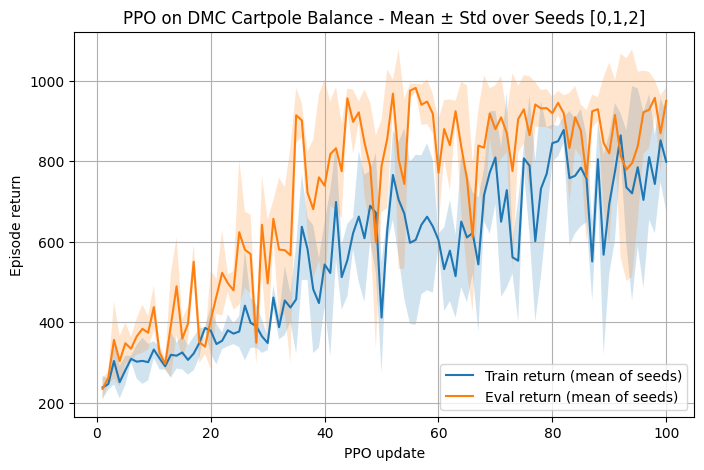

In [ ]:
import math
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torch.distributions import Normal

# =========================
# Hyperparameters
# =========================
GAMMA = 0.99
GAE_LAMBDA = 0.95
CLIP_COEF = 0.2
ENTROPY_COEF = 0.0
VALUE_COEF = 0.5
MAX_GRAD_NORM = 0.5

LR = 3e-4

ROLLOUT_STEPS = 2048   # environment steps per PPO update
NUM_UPDATES = 100      # PPO updates per seed

NUM_MINIBATCHES = 32
NUM_EPOCHS = 10

ENV_MAX_STEPS_PER_EPISODE = 1000  # safety cap


# =========================
# Helper: evaluate policy
# =========================
def evaluate_policy(env, model, device, n_episodes=5):
    """Run deterministic policy and return average episode return."""
    model.eval()
    returns = []

    for _ in range(n_episodes):
        state = env.reset()
        done = False
        ep_return = 0.0
        steps = 0

        while not done and steps < ENV_MAX_STEPS_PER_EPISODE:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                mu, log_std, value = model(state_tensor)
                # Deterministic: use mean
                action = mu.squeeze(0).cpu().numpy()

            action = np.clip(action, env.act_low, env.act_high)
            next_state, reward, done, info = env.step(action)
            ep_return += reward
            state = next_state
            steps += 1

        returns.append(ep_return)

    model.train()
    return float(np.mean(returns))


# =========================
# Training function (one seed)
# =========================
def train_single_seed(seed):
    """Train PPO for one seed and return train/eval returns per update."""
    # Environment and model
    train_env = DMControlCartpoleWrapper(seed=seed)
    obs_dim = train_env.obs_dim
    act_dim = train_env.act_dim

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[Seed {seed}] Using device:", device)

    model = ActorCritic(obs_dim, act_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LR)

    buffer = RolloutBuffer(
        buffer_size=ROLLOUT_STEPS,
        obs_dim=obs_dim,
        act_dim=act_dim,
        device=device,
    )

    train_returns_per_update = []
    eval_returns_per_update = []

    global_step = 0

    for update in range(1, NUM_UPDATES + 1):
        buffer.clear()
        episode_returns = []
        episode_return = 0.0

        state = train_env.reset()

        # -------- Rollout collection --------
        for step in range(ROLLOUT_STEPS):
            global_step += 1

            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action_tensor, log_prob_tensor, entropy_tensor, value_tensor = model.get_action_and_value(state_tensor)

            action = action_tensor.squeeze(0).cpu().numpy()
            log_prob = float(log_prob_tensor.squeeze(0).cpu().item())
            value = float(value_tensor.squeeze(0).cpu().item())

            next_state, reward, done, info = train_env.step(action)

            buffer.add(
                state=state,
                action=action,
                reward=reward,
                done=float(done),
                log_prob=log_prob,
                value=value,
            )

            episode_return += reward
            state = next_state

            if done or (step + 1) % ENV_MAX_STEPS_PER_EPISODE == 0:
                episode_returns.append(episode_return)
                episode_return = 0.0
                state = train_env.reset()

            if buffer.is_full():
                break

        # -------- GAE and returns --------
        with torch.no_grad():
            last_state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            _, _, last_value_tensor = model.forward(last_state_tensor)
            last_value = float(last_value_tensor.squeeze(0).cpu().item())

        states, actions, old_log_probs, returns, advantages = buffer.compute_returns_and_advantages(
            last_value=last_value,
            gamma=GAMMA,
            gae_lambda=GAE_LAMBDA,
        )

        batch_size = states.size(0)
        minibatch_size = batch_size // NUM_MINIBATCHES

        # -------- PPO update --------
        for epoch in range(NUM_EPOCHS):
            indices = torch.randperm(batch_size, device=device)
            for start in range(0, batch_size, minibatch_size):
                end = start + minibatch_size
                mb_idx = indices[start:end]

                mb_states = states[mb_idx]
                mb_actions = actions[mb_idx]
                mb_old_log_probs = old_log_probs[mb_idx]
                mb_returns = returns[mb_idx]
                mb_advantages = advantages[mb_idx]

                new_log_probs, entropy, values = model.get_log_prob_and_value(mb_states, mb_actions)

                log_ratio = new_log_probs - mb_old_log_probs
                ratio = torch.exp(log_ratio)

                surr1 = ratio * mb_advantages
                surr2 = torch.clamp(ratio, 1.0 - CLIP_COEF, 1.0 + CLIP_COEF) * mb_advantages
                policy_loss = -torch.min(surr1, surr2).mean()

                value_loss = (mb_returns - values).pow(2).mean()
                entropy_loss = entropy.mean()

                loss = policy_loss + VALUE_COEF * value_loss - ENTROPY_COEF * entropy_loss

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_NORM)
                optimizer.step()

        # -------- Logging --------
        if len(episode_returns) > 0:
            avg_train_return = float(np.mean(episode_returns))
        else:
            avg_train_return = 0.0
        train_returns_per_update.append(avg_train_return)

        avg_eval_return = evaluate_policy(train_env, model, device, n_episodes=5)
        eval_returns_per_update.append(avg_eval_return)

        print(
            f"[Seed {seed}] Update {update:03d}/{NUM_UPDATES} | "
            f"Train return: {avg_train_return:.2f} | "
            f"Eval return: {avg_eval_return:.2f}"
        )

    # Save model (optional)
    torch.save(model.state_dict(), f"ppo_cartpole_seed{seed}.pth")

    return train_returns_per_update, eval_returns_per_update


# =========================
# Run all seeds in one go
# =========================
seeds = [0, 1, 2]

all_train_returns = []
all_eval_returns = []

for seed in seeds:
    print(f"\n========== Training for seed {seed} ==========")
    train_ret, eval_ret = train_single_seed(seed)
    all_train_returns.append(train_ret)
    all_eval_returns.append(eval_ret)

    # Plot per-seed curves immediately
    updates = np.arange(1, NUM_UPDATES + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(updates, train_ret, label=f"Train (seed {seed})")
    plt.plot(updates, eval_ret, label=f"Eval (seed {seed})")
    plt.xlabel("PPO update")
    plt.ylabel("Episode return")
    plt.title(f"PPO on DMC Cartpole Balance - Seed {seed}")
    plt.legend()
    plt.grid(True)
    plt.show()

all_train_returns = np.array(all_train_returns)  # shape: (3, NUM_UPDATES)
all_eval_returns = np.array(all_eval_returns)    # shape: (3, NUM_UPDATES)

print("\n=== Finished all seeds ===")
print("all_train_returns shape:", all_train_returns.shape)
print("all_eval_returns shape:", all_eval_returns.shape)

# =========================
# Mean ± std across seeds
# =========================
updates = np.arange(1, NUM_UPDATES + 1)

train_mean = all_train_returns.mean(axis=0)
train_std = all_train_returns.std(axis=0)

eval_mean = all_eval_returns.mean(axis=0)
eval_std = all_eval_returns.std(axis=0)

plt.figure(figsize=(8, 5))
plt.plot(updates, train_mean, label="Train return (mean of seeds)")
plt.fill_between(updates, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(updates, eval_mean, label="Eval return (mean of seeds)")
plt.fill_between(updates, eval_mean - eval_std, eval_mean + eval_std, alpha=0.2)

plt.xlabel("PPO update")
plt.ylabel("Episode return")
plt.title("PPO on DMC Cartpole Balance - Mean ± Std over Seeds [0,1,2]")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# =========================
# Final evaluation on env seed = 10
# =========================

# Choose which training seed's model to evaluate.
# For example, use the policy trained with seed 0:
eval_model_seed = 0  # change to 1 or 2 if you want

# Create evaluation environment with seed = 10
eval_env = DMControlCartpoleWrapper(seed=10)
obs_dim = eval_env.obs_dim
act_dim = eval_env.act_dim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Final evaluation device:", device)

# Rebuild the model and load the saved parameters
eval_model = ActorCritic(obs_dim, act_dim).to(device)
state_dict_path = f"ppo_cartpole_seed{eval_model_seed}.pth"
eval_model.load_state_dict(torch.load(state_dict_path, map_location=device))

# Evaluate on seed 10 (e.g., 10 episodes)
avg_return_seed10 = evaluate_policy(eval_env, eval_model, device, n_episodes=10)

print(f"Final evaluation on env seed = 10 using model from training seed = {eval_model_seed}:")
print(f"Average episode return over 10 episodes: {avg_return_seed10:.2f}")

In [ ]:
import csv
import numpy as np

# Make sure these exist from the training cell:
# seeds, all_train_returns, all_eval_returns, NUM_UPDATES

log_filename = "ppo_cartpole_logs.csv"

with open(log_filename, mode="w", newline="") as f:
    writer = csv.writer(f)
    # Header
    writer.writerow(["update", "seed", "train_return", "eval_return"])

    updates = np.arange(1, NUM_UPDATES + 1)

    for seed_idx, seed in enumerate(seeds):
        train_ret = all_train_returns[seed_idx]
        eval_ret = all_eval_returns[seed_idx]
        for u, tr, er in zip(updates, train_ret, eval_ret):
            writer.writerow([u, seed, tr, er])

print(f"Saved logs to {log_filename}")

Saved logs to ppo_cartpole_logs.csv
